# Convolutional neural networks for artistic style transfer

This iPython notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) that demonstrates how to use neural networks to transfer artistic style from one image onto another. It is meant to go along with a [related blog post](https://harishnarayanan.org/writing/artistic-style-transfer/) that provides more context, and explains a lot of the theory behind the steps that follow.

This implementation is not meant to be a standalone way to run this sort of style transfer in practice. If you're interested in doing so, you should take a look at the companion file `neural_style_transfer.py` that allows for more general and batch use. Both these files require the Python packages specified in `requirements.txt` to be installed to work.

There will be a companion blog post and project coming soon in the future that implements a much faster version of this algorithm ([Johnson et al., 2016](https://arxiv.org/abs/1603.08155)) and wraps it in a webapp, a la [Prisma](https://prisma-ai.com).

In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## Load and preprocess the content and style images

Our first task is to load the content and style images. Note that the content image we're working with is not particularly high quality, but the output we'll arrive at the end of this process still looks really good.

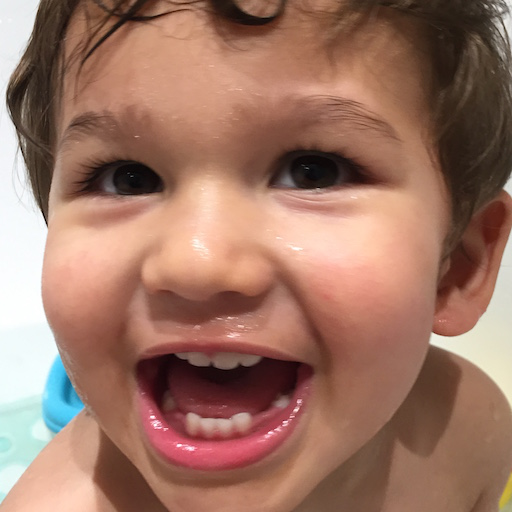

In [2]:
height = 512
width = 512

content_image_path = 'images/hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

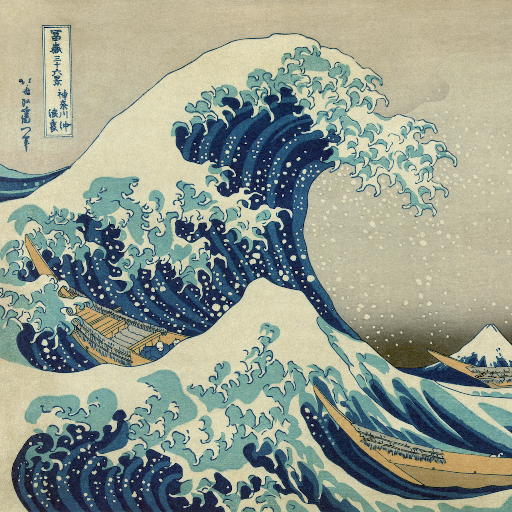

In [3]:
style_image_path = 'images/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to massage this input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduces the *VGG Network* model that we're going to use shortly.

For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the *combination* image that retains the content of the content image while incorporating the style of the style image.

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Reuse a model pre-trained for image classification

The core idea introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the *feature spaces* provided by one such model to independently work with content and style of images.

The original paper uses the 19 layer VGG network model from [Simonyan and Zisserman (2015)](todo), but we're going to instead follow [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) and use the 16 layer (VGG16). There is no noticeable qualitative difference in making this choice, and we gain a tiny bit in speed.

Also, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the part of the model marked in green in the table below.

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

It is trivial for us to get access to this because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

In [8]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

As is clear from the table above, this model has a lot of layers. Keras has its own names for these layers and the blocks within them. Let's get these names so that we can easily refer to the individual blocks we want to later access in constructing our loss function for style transfer.

In [9]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(3

If you stare at the list above, you'll convince yourself that we covered all items we wanted in the table (the cells marked in green). Notice also that because we provided Keras with an input tensor, the various TensorFlow tensors get well-defined shapes.

The crux of Gatys et al. (2015) (merged with ideas from Johnson et al. (2016)) is that the loss function for the style transfer problem can be broken into three distinct parts: the content loss, the style loss and the total variation loss.

In [10]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

loss = backend.variable(0.)

### The content loss

In [11]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2'] # From Johnson, not as defined in Gatys
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

In [12]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [13]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss (regulariser)

In [14]:
# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert backend.ndim(x) == 4
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

In [15]:
loss += total_variation_weight * total_variation_loss(combination_image)

In [16]:
def deprocess_image(x):
    x = x.reshape((height, width, 3))
    x = x[:, :, ::-1]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [17]:
# Get the gradients of the generated image wrt the loss
grads = backend.gradients(loss, combination_image)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = backend.function([combination_image], outputs)

In [18]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [19]:
# This Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [20]:
# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = 'images/combined_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 7.72046e+10
Image saved as images/combined_0.png
Iteration 0 completed in 376s
Start of iteration 1
Current loss value: 4.93965e+10
Image saved as images/combined_1.png
Iteration 1 completed in 386s
Start of iteration 2
Current loss value: 4.18685e+10
Image saved as images/combined_2.png
Iteration 2 completed in 377s
Start of iteration 3
Current loss value: 3.89794e+10
Image saved as images/combined_3.png
Iteration 3 completed in 380s
Start of iteration 4
Current loss value: 3.75961e+10
Image saved as images/combined_4.png
Iteration 4 completed in 386s
Start of iteration 5
Current loss value: 3.67527e+10
Image saved as images/combined_5.png
Iteration 5 completed in 378s
Start of iteration 6
Current loss value: 3.62673e+10
Image saved as images/combined_6.png
Iteration 6 completed in 419s
Start of iteration 7
Current loss value: 3.59316e+10
Image saved as images/combined_7.png
Iteration 7 completed in 370s
Start of iteration 8
Current loss value:

It took a while (because the computer I ran this notebook on isn't GPU-accelerated), but here is the beautiful output from the last iteration.

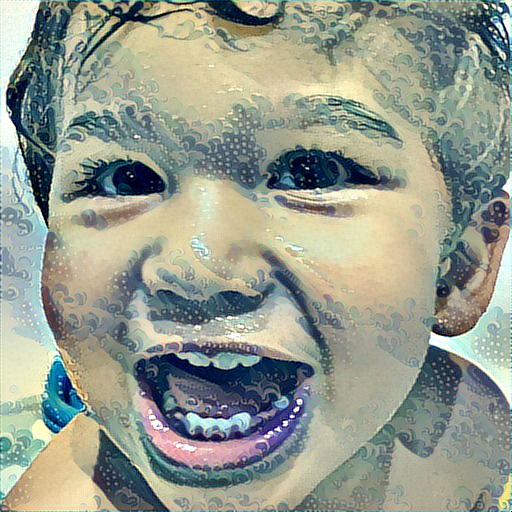

In [21]:
Image.fromarray(img)

### Notes

The VGG network was originally created for image classification. But it turns out that when trained for this purpose, the feature spaces extracted from intermediate layers allows one to separate aspects of an image's content from its style.

The general idea behind Gatys et al. (2015) is that we're going to setup an optimisation problem that aims to solve for a *combination image* that contains the content of the content image, while having the style of the style image. This combination image begins its life as a random collection of pixels, and we use L-BFGS to iteratively improve upon it.